In [1]:
from classiq import *
from classiq.qmod.symbolic import logical_or
from classiq.execution import ExecutionPreferences

#Setting ip the initial parameters such that we have 16 nodes.
size = 4 
num_nodes = 2**size 


# Function to prepare the |-> state
@qfunc
def prepare_minus(x: QBit):
    X(x)
    H(x)

#Function that performs the XOR operation
@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
    aux^=(x!=0)

#Function implementing the phase kickback calling the "prepare_minus" function to initialize the state |-> and
#the "diffuzer_oracle" to implement the phase kickback
@qfunc
def zero_diffuzer(x: QNum):
    aux = QNum('aux')
    allocate(1,aux)
    within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)

#Function to implement the "coin" flip. We define the probabilities for the jumps to the adjacent vertices and we call the "zero_diffuzer" to 
#implement the coin flip
def C_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):
    prob = [0]*num_nodes  
    if i == 0:
        prob[i + 1] = 1.0 
    elif i == num_nodes - 1:
        prob[i - 1] = 1.0  
    else:
        prob[i - 1] = 0.5 
        prob[i + 1] = 0.5  
    print(f'Node={i}, prob vec ={prob}')
    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))

#Function to implement the coin flip for all the vertices of the configuration (here 16).
@qfunc 
def C_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(num_nodes):
        C_iteration(i,vertices,adjacent_vertices)

In [2]:
#Function to check whether two quantum numbers "vertices" and "adjacent_vertices" are consecutive or not. This, essentially, check wether two 
#vertices are adjacent or not.
@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
    res |= (((vertices - adjacent_vertices) == 1) | ((vertices - adjacent_vertices) == -1))

#Function that swaps the content of two series of bits
@qfunc 
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
    repeat(count= x.len,
           iteration= lambda i: SWAP(x[i],y[i])) 

#Function that applies the jump by swapping the quantum states of "vertices" and "adlacent_vertices" conditioned to the check that these quantum
#variables correspond to adjacent vertices
@qfunc 
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))

In [3]:
#Function that initializes the quantum states of "vertices" and "adjacent_vertices" and inplements the random quantum jump by applying the "C_operator" 
#followed by the "S_operator"
@qfunc 
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):
    allocate(size, vertices) 
    hadamard_transform(vertices)
    allocate(size, adjacent_vertices)
    C_operator(vertices, adjacent_vertices) 
    S_operator(vertices, adjacent_vertices) 

In [7]:
# Code that creates and synthesizes the quantum model
qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

Node=0, prob vec =[0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
Node=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
Node=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
Node=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
Node=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
Node=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
Node=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
Node=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0]
Node

# Discussion
## Algorithm description
This algorithm implements a quantum random walk on a straight line consisting of 16 nodes as depicted below:
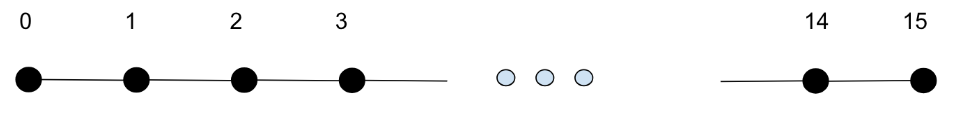

The algorithm consists of two main operations: 1) the coin operator and 2) the shift operator. The first one is responsible for defining the probabilities of each step in a given direction, making potentially some directions forbidden, i.e. by respecting the boundaries of the line segment at the nodes 0 and 15. The second operator is the one implementing the random walk, specifying jumps between vertices. In what follows, we describe step-by-step the algorithm. 

The first function "prepare_minus" is used for state preparation. In particular, it initializes an auxiliary qubit to the state $\ket{-}=\frac{1}{\sqrt{2}}(\ket{0}-\ket{1})$, which is needed for the phase kickback algorithm implemented by the function "zero_diffuzer". This state is prepared by acting with the Pauli $X$ operator to the state $\ket{0}$, followed by the Hadamard operator. Then, we define two functions that are important components of the "coin" operator. Firstly, we define the "diffuzer_oracle", which takes the quantum number of interest "x" (here, representing a particular node) and checks whether it is zero or not. Then, it performs the bitwise XOR of the outcome with the "aux" variable.  Next, the "zero_diffuzer" function performs the phase kickback. First, one qubit is allocated to the variable "aux" which is prepared in the $\ket{-}$ state, and the "diffuzer_oracle" is applied. Finally, the "coin" function is defined as "C_iteration". In this function, we first set the probabilities for jumping from one vertex to another. We assign $50\%$ to left and right jumps. Particular care is needed for the boundaries of the line segment, i.e. for nodes 0 and 15. So, we assign a $100\%$ probability to jump right when located in node 1, since there is no any left nodes there. Similarly, we assign a $100\%$ probability for a left jump when located in node 15. Then, the control phase kickback is applied. In particular, when a given integer variable "i" matches the quantum number "vertices" corresponding to the label of a specified vertex, then the "zero_diffuzer" is called to perform the phase kickback operation for the quantum number "adjacent_vertices" which is initiated based on the specified value of the "vertices" quantum number and probability distributions defined earlier. Essentially, the preparation of the quantum state of "adjacent_vertices" amounts to informing the algorithm about the available paths, and calling the "zero_diffuzer" amounts to flipping the coin about which direction to follow. Finally, we define the "C_operator" which is a function that executes the "C_iteration" function for all the nodes of the given configuration.

The next important operation is to actually implement the walk based on the result of the coin flip. This is performed by the function "S_operator". First, we define the "edge_oracle" function. This function takes as inputs the "vertices" and "adjacent_vertices" variables, subtracts them, and checks whether the result is $\pm 1$. It stores the logic result of the operation to a "res" qubit. The purpose of the "edge_oracle" is to check whether the variables "vertices" and "adjacent_vertices" correspond to (truly) adjacent vertices, in which way the jump from the former to the latter should be permitted. Then, the "bitwise_swap" function is defined, which exchanges the content of two given quantum states "x" and "y". Finally, the "S_opeartor" function is defined. This function takes as inputs the quantum numbers "vertices" and "adjacent_vertices". Within the function, the quantum variable "res" is first initialized. Then, the "edge_oracle" function is called. The output of the "edge_oracle" is stored in "res". Then, a controlled operation is defined that implements the jump. In particular, if "res" is 1, it means that the specified "vertices" and "adjacent_vertices" describe adjacent vertices. In that case, the "bitwise_swap(vertices,adjacent_vertices)" function is called which implements the swap of the states of "vertices" and "adjacent_vertices". This final part implements the desired jump from a given vertex to one of its adjacent ones. 

Finally, the "main" function is defined, which performs the jump by calling the defined functions above. More precisely, we first allocate 4 qubits for each of the "vertices" and "adjacent_vertices" quantum numbers. We need 4 qubits because the maximum number labeling a node is 15 since, in binary, 15 is 1111, which needs 4 bits to represent it. Then, a Hadamard is applied to the "vertices" quantum number creating equal superpositions of its possible states. Finally, the "C_operator" and "S_operator" functions are called to implement the jump.

In the last cell, we synthesize and execute the quantum program. We also print the probabilities of vertex jump. The output confirms that the jump probabilities have been defined properly as for each of the middle vertices there is a $50\%-50\%$ jumping left-right, but for the boundary vertices the only possibility is to jump toward the interior. 

## Synthesized Circuit

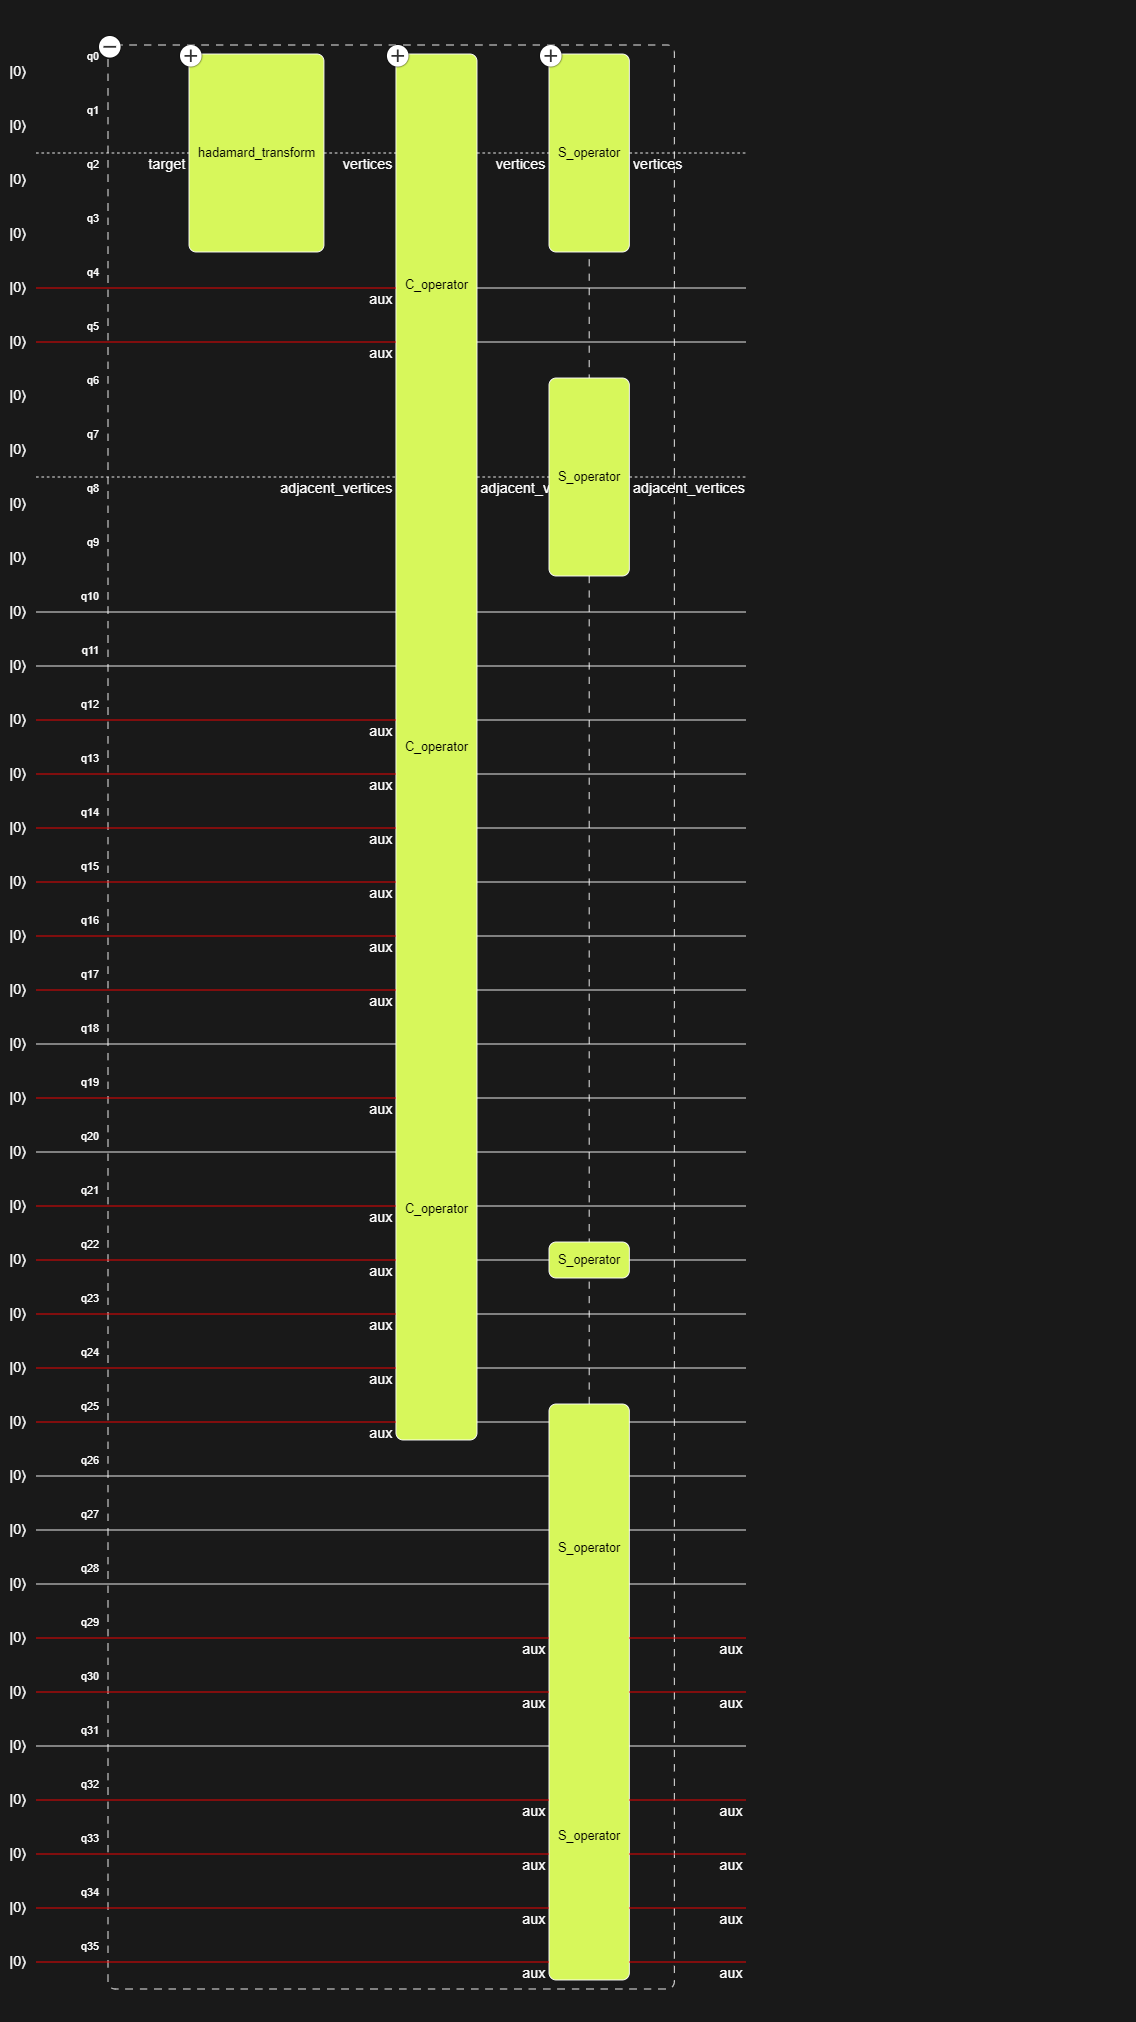

In the synthesized circuit, there are three main families of operations: 1) the Hadamrd that prepares the quantum number "vertices", made of 4 qubits, to equal superposition of its possible states, 2) the "C_operator" implementing the coin flip, and the "S_operator" implementing the jump from "vertices" to "adjacent_vertices" depending on the outcome of the coin flip. For its execution, my quantum program needed: width=26 and depth=5181.

Below, I am showing a screenshot of a part of the "C_operator", where I "zoomed in"

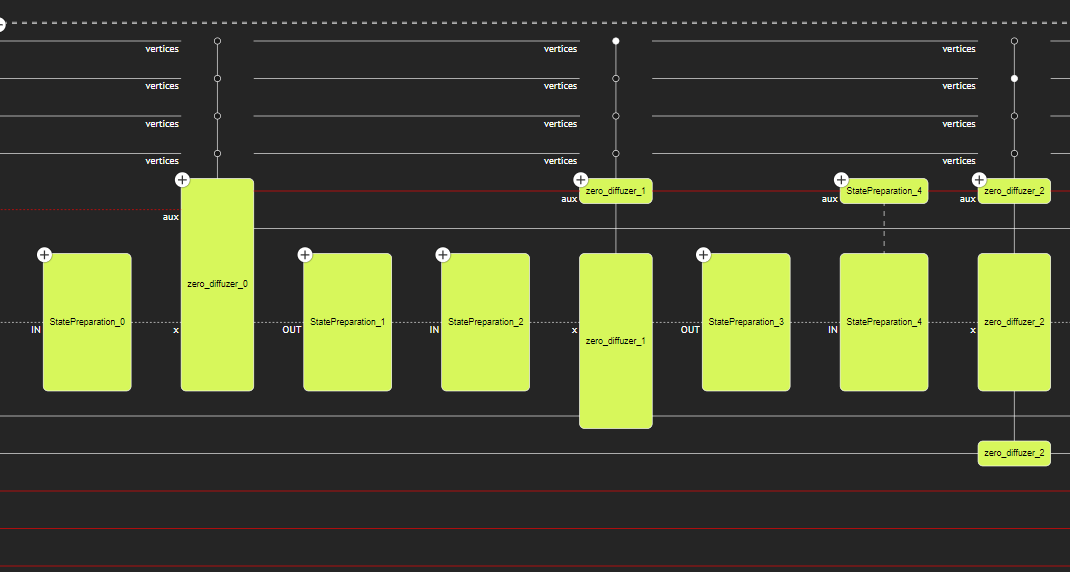

Notice the series of state preparation and zero_deffuzer actions. This corresponds to preparing the $\ket{-}$ state for the several phase kickback operations made by the zero_diffuzer for the several vertices. 

Also, by "zooming in" the "S_operator", we can see the combination of the "edge_oracle", which checks whether the two vertices under study are adjacent, and the "bitwise_swap", which performs the jump. These two functions comprise the "S_operator"

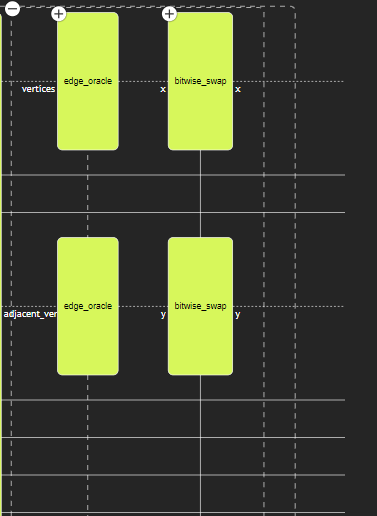